## Get data

### Get data from yfinance

In [3]:
from pandas_datareader import data as pdr
from datetime import date
import yfinance as yf
yf.pdr_override()
import pandas as pd

ticker_list=["AAPL", "MSFT", "AMZN", "FB", "TSLA", "NVDA", "GOOG", "GOOGL", "CSCO", "AVGO"]
today = date.today()
# We can get data by our choice by giving days bracket
start_date= "2013-01-01"
end_date="2020-11-30"

files=[]
def getData(ticker):
    data = pdr.get_data_yahoo(ticker, start=start_date, end=today)
    # dataname= ticker+"_"+str(today)
    files.append((data,ticker))
    
for tik in ticker_list:
    getData(tik)
    
    



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Setup firebase

In [1]:
import firebase_admin

cred_obj = firebase_admin.credentials.Certificate('../../../fyp2022-stockpriceprediction-firebase-adminsdk-ku62m-f9ed330292.json')
fyp_app = firebase_admin.initialize_app(cred_obj, {
	'databaseURL':"https://fyp2022-stockpriceprediction-default-rtdb.asia-southeast1.firebasedatabase.app/",
	'storageBucket': 'fyp2022-stockpriceprediction.appspot.com'
	})

### Upload data into firebase

In [6]:
from firebase_admin import db
from datetime import datetime as dt

for file in files:
    
    tick = file[1]
    data = file[0]
    data['Ticker'] = tick
    
    #convert date index to string, as firebsae cant have datetime as an index
    data.index = data.index.strftime("%Y-%m-%d")
    
    #convert the dataframe to json/dictionary
    data_dict = data.to_dict(orient="index")
    
    #upload it to the database
    ref = db.reference("/data/"+tick)
    ref.set(data_dict)

### Get data from firebase database

In [2]:
from matplotlib import pyplot as plt
from firebase_admin import db
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
ref = db.reference("/data")
data = ref.get()

### LSTM

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
from zipfile import ZipFile
import pickle
import os
from firebase_admin import storage
from sklearn.metrics import mean_squared_error
tf.debugging.set_log_device_placement(True)

def get_all_file_paths(directory):
  
    # initializing empty file paths list
    file_paths = []
  
    # crawling through directory and subdirectories
    for root, directories, files in os.walk(directory):
        for fileName_model in files:
            # join the two strings in order to form the full filepath.
            filepath = os.path.join(root, fileName_model)
            file_paths.append(filepath)
  
    # returning all file paths
    return file_paths



try:
  # Specify an invalid GPU device
  #with tf.device('/device:GPU:2'):
  
  with tf.device('/device:GPU:2'):
    for tick, stock_data in data.items():
      print(tick)
      df = pd.DataFrame(stock_data).T
      df = df.reset_index()['Close']
      scaler = MinMaxScaler(feature_range=(0,1))
      df=scaler.fit_transform(np.array(df).reshape(-1,1))
      train_data = df[:int(0.9*len(df))]
      test_data = df[int(0.9*len(df)):]
      train_data = train_data.reshape(-1,1)
      test_data = test_data.reshape(-1,1)
      
      def create_dataset(dataset, time_step=1):
          dataX, dataY = [], []
          for i in range(len(dataset)-time_step-1):
              a = dataset[i:(i+time_step), 0]
              dataX.append(a)
              dataY.append(dataset[i + time_step, 0])
          return np.array(dataX), np.array(dataY)
      time_step = 100
      X_train, y_train = create_dataset(train_data, time_step)
      X_test, ytest = create_dataset(test_data, time_step)
      
      X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
      X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
      
      model=Sequential()
      model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
      model.add(LSTM(50,return_sequences=True))
      model.add(LSTM(50))
      model.add(Dense(1))
      model.compile(loss='mean_squared_error',optimizer='adam')
      history = model.fit(X_train, y_train,epochs=10)
      
      
      # calling function to get all file paths in the directory
      filepath_model = "../../../data/models/" + tick + "/lstm"
      model.save(filepath_model)
      file_paths = get_all_file_paths(filepath_model)

      
      #took help from this: https://www.geeksforgeeks.org/working-zip-files-python/
      with ZipFile(filepath_model + ".zip",'w') as zip:
              # writing each file one by one
              for file in file_paths:
                  zip.write(file)
      
      
      fileName_model = "lstm"
      bucket = storage.bucket()
      #upload models
      blob = bucket.blob("models/" + tick + "/" + fileName_model)
      blob.upload_from_filename(fileName_model+".zip")
      
      #upload normalizer
      filepath_normalizer = "../../../data/normalizers/" + tick + "/lstm.pkl"
      pickle.dump(scaler, open(filepath_normalizer, 'wb'))

      filename_normalizer = "lstm.pkl"
      blob = bucket.blob("normalizers/" + tick + "/" + filename_normalizer)
      blob.upload_from_filename(filename_normalizer)
      
      # Opt : if you want to make public access from the URL
      #blob.make_public()
    # checking whether folder exists or not
    folder_path = filepath_model
    if os.path.exists(folder_path):

        # checking whether the folder is empty or not
        if len(os.listdir(folder_path)) == 0:
            # removing the file using the os.remove() method
            os.rmdir(folder_path)
        else:
            # messaging saying folder not empty
            print("Folder is not empty")
    else:
        # file not found message
        print("File not found in the directory")
      
except RuntimeError as e:
  print(e)

In [64]:
test_predict=model.predict(X_test)
test_predict=scaler.inverse_transform(test_predict)

ytest = scaler.inverse_transform(ytest.reshape(-1,1))
error = math.sqrt(mean_squared_error(ytest,test_predict))
error    

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Option

73.64311682215732

In [24]:
X_test

(127, 100, 1)

In [47]:
train_predict=model.predict(X_train)
train_predict=scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1,1))
math.sqrt(mean_squared_error(y_train,train_predict))

3.0307830607276087

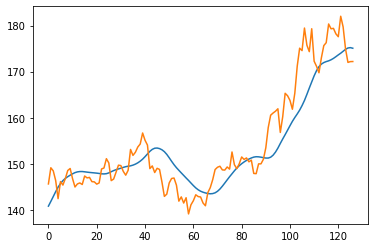

In [11]:
plt.plot(test_predict)
plt.plot(ytest)
plt.show()

In [26]:
# specifying the zip file name
file_name = "AAPL_model.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
AAPL_model/keras_metadata.pb                   2022-01-12 19:16:08        17068
AAPL_model/saved_model.pb                      2022-01-12 19:16:08      2382689
AAPL_model/variables/variables.data-00000-of-00001 2022-01-12 19:16:08       618372
AAPL_model/variables/variables.index           2022-01-12 19:16:08         2731
Extracting all the files now...
Done!


In [110]:
#get the last 100 days and make a prediction
tick = 'AAPL'
def getTestData(ticker, start):
    data = pdr.get_data_yahoo(ticker, start=start, end=today)
    # dataname= ticker+"_"+str(today)
    return data[-100:]
    
   
   
from datetime import datetime, timedelta
start = d = today - timedelta(days=190)

df = getTestData(tick,start) 

#df = pd.DataFrame(stock_data).T
df = df.reset_index()['Close']
df=scaler.transform(np.array(df).reshape(-1,1))
test_data = df.reshape(-1,1)

import keras.models
model = keras.models.load_model(tick + '_model')
prediction = model.predict( np.array( [test_data,] )  )
scaler.inverse_transform(prediction)

[*********************100%***********************]  1 of 1 completed
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replic

array([[174.37128]], dtype=float32)

### Arima

In [73]:
from pmdarima.arima import auto_arima

stock_data = data['AAPL']
df = pd.DataFrame(stock_data).T

data = df.sort_index(ascending=True, axis=0)

train = data[:-2]
valid = data[-2:]

training = train['Close']
validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.47 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=8903.869, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=8357.856, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.92 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=8891.064, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=8009.664, Time=0.47 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.58 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=8023.083, Time=0.39 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=8011.656, Time=0.56 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=8011.619, Time=1.13 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=8009.624, Time=0.50 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=8358.974, Time=0.24 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=2.62 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=i

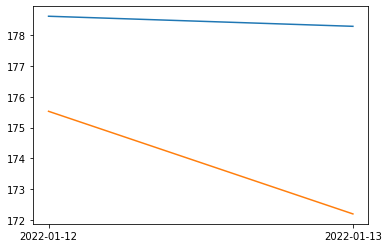

In [74]:
from matplotlib import pyplot as plt

plt.plot(forecast['Prediction'],label='Prediction')
plt.plot(valid['Close'], label='True value')
plt.show()

### Prophet

In [27]:
#importing prophet
from fbprophet import Prophet

stock_data = data['AAPL']
df = pd.DataFrame(stock_data).T

#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']

#preparing data
new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:-10]
valid = new_data[-10:]

#fit the model
model = Prophet()
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

ModuleNotFoundError: No module named 'fbprophet'

### Custom ANN (wih MA, H-L, O-C, etc.)

In [58]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import math
from zipfile import ZipFile
import pickle
import os
from firebase_admin import storage
from sklearn.metrics import mean_squared_error

In [50]:
data.keys()

dict_keys(['AAPL', 'AMZN', 'AVGO', 'CSCO', 'FB', 'GOOG', 'GOOGL', 'MSFT', 'NVDA', 'TSLA'])

In [65]:
histories = {}

def get_all_file_paths(directory):
  
    # initializing empty file paths list
    file_paths = []
  
    # crawling through directory and subdirectories
    for root, directories, files in os.walk(directory):
        for fileName_model in files:
            # join the two strings in order to form the full filepath.
            filepath = os.path.join(root, fileName_model)
            file_paths.append(filepath)
  
    # returning all file paths
    return file_paths
    
for tick in data.keys():
    stock_data = data['FB']
    df = pd.DataFrame(stock_data).T
    df['H-L'] = df['High'] - df['Low']
    df['O-C'] = df['Open'] - df['Close']
    df['7MA'] = df['Adj Close'].rolling(window=7).mean()
    df['14MA'] = df['Adj Close'].rolling(window=14).mean()
    df['21MA'] = df['Adj Close'].rolling(window=21).mean()
    df['7SD'] = df['Adj Close'].rolling(window=7).std()

    features = ['H-L','O-C','7MA','14MA','21MA','7SD','Volume','Close']
    df = df[features].apply(pd.to_numeric)
    df_final = df[20:].copy()
    df_final['Close'] = df_final['Close'].shift(1)

    features = ['H-L','O-C','7MA','14MA','21MA','7SD','Volume']
    #https://stackoverflow.com/questions/36926140/how-to-convert-numpy-arrays-to-standard-tensorflow-format
    X = np.asarray(df_final[1:][features], np.float32)
    Y = np.asarray(df_final[1:]['Close'], np.float32)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

    y_train = y_train.reshape(-1,1)
    scaler_x = MinMaxScaler().fit(X_train)
    scaler_y = MinMaxScaler().fit(y_train)

    X_train = scaler_x.transform(X_train)
    y_train = scaler_y.transform(y_train)
    # Defining the Input layer and FIRST hidden layer, both are same!
    model = Sequential()
    model.add(Dense(units=50, input_dim=7, kernel_initializer='normal', activation='relu'))
    
    # Defining the Second layer of the model
    # after the first layer we don't have to specify input_dim as keras configure it automatically
    model.add(Dense(units=25, kernel_initializer='normal', activation='tanh'))

    model.add(Dense(units=10, kernel_initializer='normal', activation='tanh'))
    
    # The output neuron is a single fully connected node 
    # Since we will be predicting a single number
    model.add(Dense(1, kernel_initializer='normal'))
    
    # Compiling the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Fitting the ANN to the Training set
    history = model.fit(X_train, y_train ,batch_size = 10, validation_split = 0.1, epochs = 180, verbose=1)

    histories[tick] = history

    filepath_model = "../../../data/models/" + tick + "/ann"
    model.save(filepath_model)
    file_paths = get_all_file_paths(filepath_model)

    
    #took help from this: https://www.geeksforgeeks.org/working-zip-files-python/
    with ZipFile(filepath_model + ".zip",'w') as zip:
            # writing each file one by one
            for file in file_paths:
                zip.write(file)
    
    
    fileName_model = "ann.zip"
    bucket = storage.bucket()
    #upload models
    blob = bucket.blob("models/" + tick + "/" + fileName_model)
    blob.upload_from_filename(filepath_model+".zip")
    
    #upload normalizer training data
    filepath_normalizer = "../../../data/normalizers/" + tick + "/ann_x.pkl"
    pickle.dump(scaler_x, open(filepath_normalizer, 'wb'))

    filename_normalizer = "ann_x.pkl"
    blob = bucket.blob("normalizers/" + tick + "/ann_x.pkl")
    blob.upload_from_filename(filepath_normalizer)

    #upload normalizer predicted value
    filepath_normalizer = "../../../data/normalizers/" + tick + "/ann_y.pkl"
    pickle.dump(scaler_y, open(filepath_normalizer, 'wb'))

    filename_normalizer = "ann_y.pkl"
    blob = bucket.blob("normalizers/" + tick + "/ann_y.pkl")
    blob.upload_from_filename(filepath_normalizer)

Epoch 1/180
163/163 [==============================] - 1s 4ms/step - loss: 0.0451 - val_loss: 0.0021
Epoch 2/180
163/163 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 5.7774e-04
Epoch 3/180
163/163 [==============================] - 1s 3ms/step - loss: 4.0813e-04 - val_loss: 3.1403e-04
Epoch 4/180
163/163 [==============================] - 1s 3ms/step - loss: 2.8470e-04 - val_loss: 3.3182e-04
Epoch 5/180
163/163 [==============================] - 1s 3ms/step - loss: 2.5519e-04 - val_loss: 3.3123e-04
Epoch 6/180
163/163 [==============================] - 1s 3ms/step - loss: 2.3791e-04 - val_loss: 3.7756e-04
Epoch 7/180
163/163 [==============================] - 1s 3ms/step - loss: 2.3366e-04 - val_loss: 2.8529e-04
Epoch 8/180
163/163 [==============================] - 1s 3ms/step - loss: 2.3683e-04 - val_loss: 3.0682e-04
Epoch 9/180
163/163 [==============================] - 0s 3ms/step - loss: 2.2459e-04 - val_loss: 2.1216e-04
Epoch 10/180
163/163 [=========

In [66]:
histories.keys()

dict_keys(['AAPL', 'AMZN', 'AVGO', 'CSCO', 'FB', 'GOOG', 'GOOGL', 'MSFT', 'NVDA', 'TSLA'])

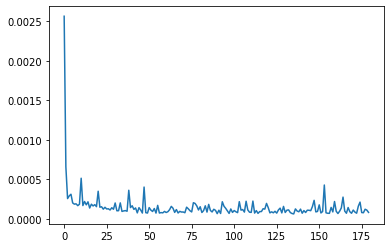

In [62]:
plt.plot(list(histories.values())[0].history['val_loss'])

In [74]:
from sklearn.metrics import mean_squared_error
y_test = y_test.reshape(-1,1)
y_test_transform = scaler_y.transform(y_test)
X_test = scaler_x.transform(X_test)
y_pred = model.predict(X_test)
mean_squared_error(y_test_transform, y_pred)

0.000102086204

In [76]:
scaler_y.inverse_transform(y_pred)

array([[275.82086 ],
       [132.01283 ],
       [137.7724  ],
       [212.44344 ],
       [186.31624 ],
       [177.45625 ],
       [ 24.046793],
       [181.95026 ],
       [ 81.453514],
       [176.90802 ],
       [183.17456 ],
       [182.11317 ],
       [105.79778 ],
       [158.21648 ],
       [196.85593 ],
       [128.52538 ],
       [189.04941 ],
       [345.6005  ],
       [265.8512  ],
       [102.1883  ],
       [113.7507  ],
       [104.49941 ],
       [ 63.362526],
       [161.01546 ],
       [186.20975 ],
       [191.63206 ],
       [146.45222 ],
       [ 45.7251  ],
       [ 65.18101 ],
       [169.92487 ],
       [142.63333 ],
       [193.73663 ],
       [ 91.46128 ],
       [180.10179 ],
       [119.68643 ],
       [105.71038 ],
       [273.8028  ],
       [139.82077 ],
       [138.38922 ],
       [ 25.708197],
       [184.50807 ],
       [ 76.17111 ],
       [282.23877 ],
       [271.3276  ],
       [ 90.22754 ],
       [174.09407 ],
       [164.25815 ],
       [179.9

In [80]:
tick = 'NVDA'
import pandas_datareader as pdr
def getTestData(ticker, start):
    data = pdr.get_data_yahoo(ticker, start=start, end=today)
    # dataname= ticker+"_"+str(today)
    return data[-100:]
    
from datetime import date  
today = date.today()

from datetime import datetime, timedelta
start = d = today - timedelta(days=190)

df = getTestData(tick,start) 

In [81]:
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']
df['7MA'] = df['Adj Close'].rolling(window=7).mean()
df['14MA'] = df['Adj Close'].rolling(window=14).mean()
df['21MA'] = df['Adj Close'].rolling(window=21).mean()
df['7SD'] = df['Adj Close'].rolling(window=7).std()

In [82]:
features

['H-L', 'O-C', '7MA', '14MA', '21MA', '7SD', 'Volume']

In [83]:
test_data = np.asarray(df[-1:][features], np.float32)
test = scaler_x.transform(test_data)
pred = model.predict(test)  
pred_price = scaler_y.inverse_transform(pred)

In [85]:
test.shape

(1, 7)

{'AAPL': <keras.callbacks.History at 0x28351a6bd00>,
 'AMZN': <keras.callbacks.History at 0x283600eeaf0>,
 'AVGO': <keras.callbacks.History at 0x2815b60a790>,
 'CSCO': <keras.callbacks.History at 0x2810cebd040>,
 'FB': <keras.callbacks.History at 0x2810c84b9d0>,
 'GOOG': <keras.callbacks.History at 0x28351a5dbb0>,
 'GOOGL': <keras.callbacks.History at 0x28364c78850>,
 'MSFT': <keras.callbacks.History at 0x281765a0ee0>,
 'NVDA': <keras.callbacks.History at 0x2833c813fa0>,
 'TSLA': <keras.callbacks.History at 0x2836b817f40>}